In [ ]:
!pip install tensorflow_data_validation

In [ ]:
# import dependencies
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import tensorflow_data_validation as tfdv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime
import calendar
import warnings
import os
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_dir = './drive/MyDrive/Colab Notebooks/smart-meters-in-london'

In [ ]:
# Read daily energy consumption dataset
df_daily = pd.read_csv(os.path.join(base_dir, "daily_dataset.csv"))

In [ ]:
df_daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


## Daily energy consumption data analysis

In [ ]:
# Generate data statistics
daily_stats = tfdv.generate_statistics_from_dataframe(df_daily)
tfdv.visualize_statistics(daily_stats)

In [ ]:
# Generate data schema
daily_schema = tfdv.infer_schema(statistics=daily_stats)
tfdv.display_schema(daily_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'LCLid',BYTES,required,,-
'day',BYTES,required,,-
'energy_median',FLOAT,optional,single,-
'energy_mean',FLOAT,optional,single,-
'energy_max',FLOAT,optional,single,-
'energy_count',INT,required,,-
'energy_std',FLOAT,optional,single,-
'energy_sum',FLOAT,optional,single,-
'energy_min',FLOAT,optional,single,-


In [ ]:
# Color Palette
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

# Dataset Columns
feature_keys = [
    "energy_median",
    "energy_mean",
    "energy_max",
    "energy_count", 
    "energy_std", 
    "energy_sum", 
    "energy_min"
]

# Plots each column as a time series
def visualize_plots(dataset, columns):
    features = dataset[columns]
    fig, axes = plt.subplots(
        nrows=len(columns)//2 + len(columns)%2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, col in enumerate(columns):
        c = colors[i % (len(colors))]
        t_data = dataset[col]
        t_data.index = dataset.index
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(col),
            rot=25,
        )
    ax.legend([col])
    plt.tight_layout()

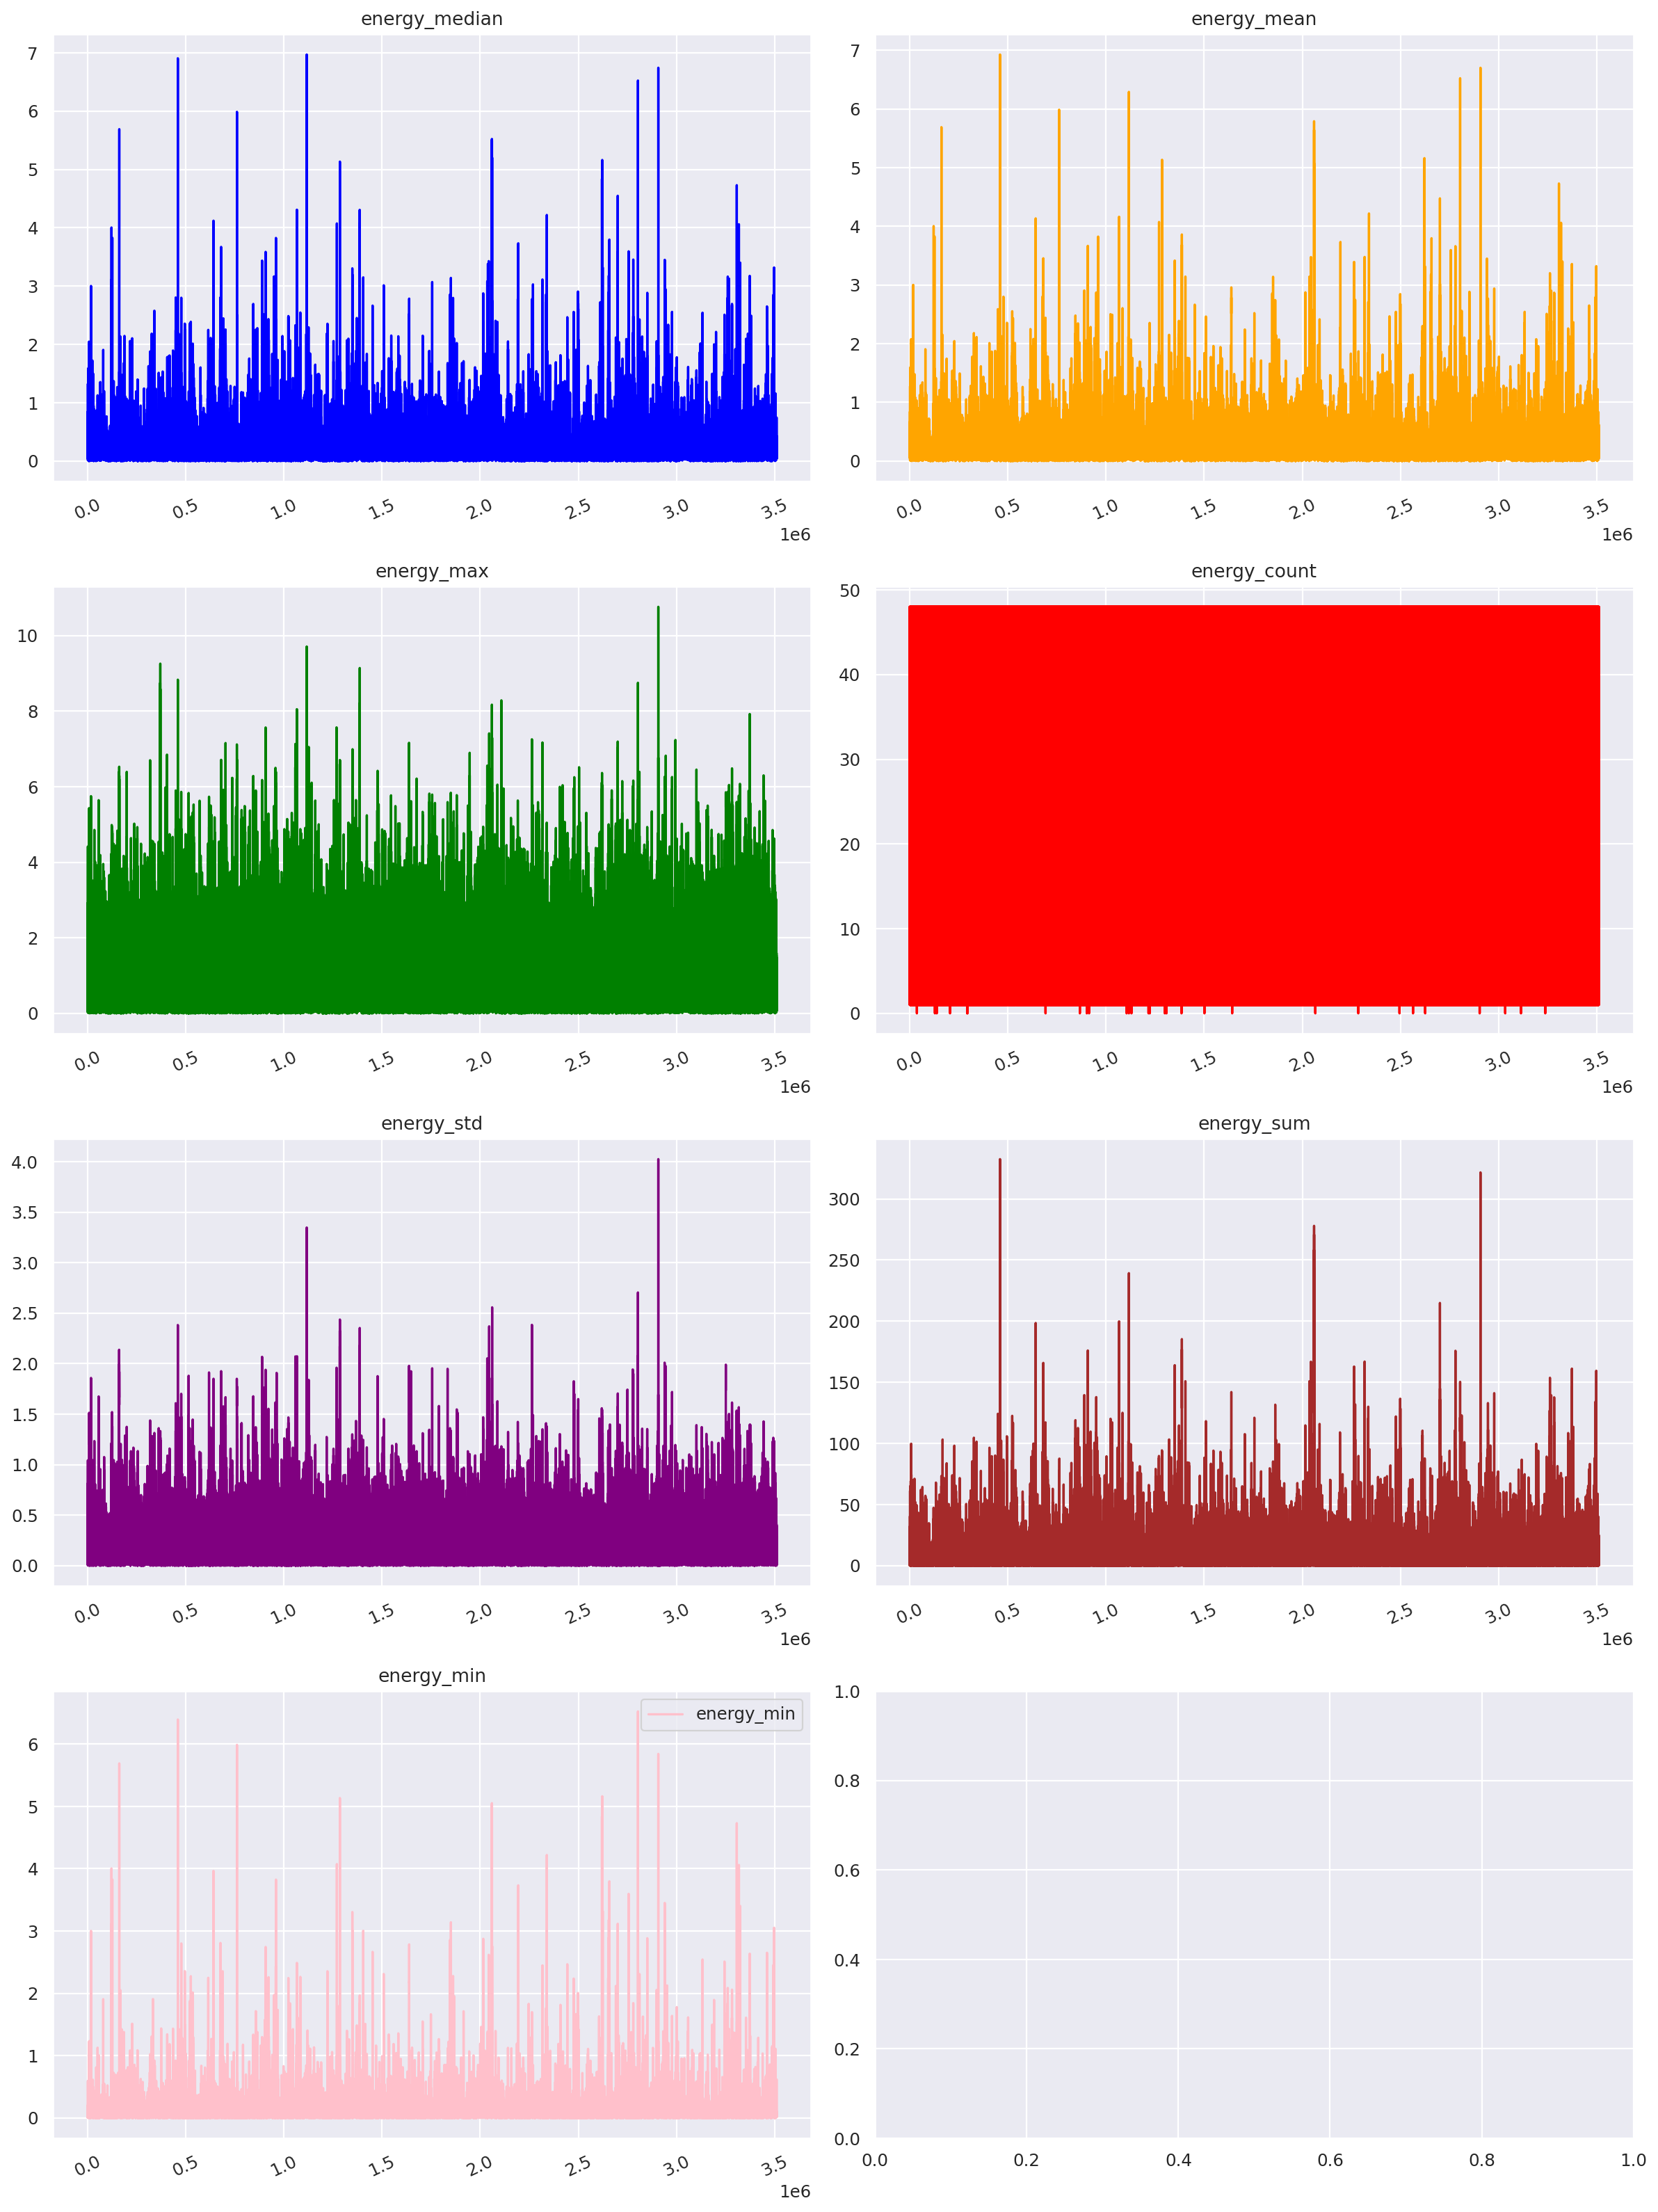

In [ ]:
# Plot numeric features time series
visualize_plots(df_daily, feature_keys)

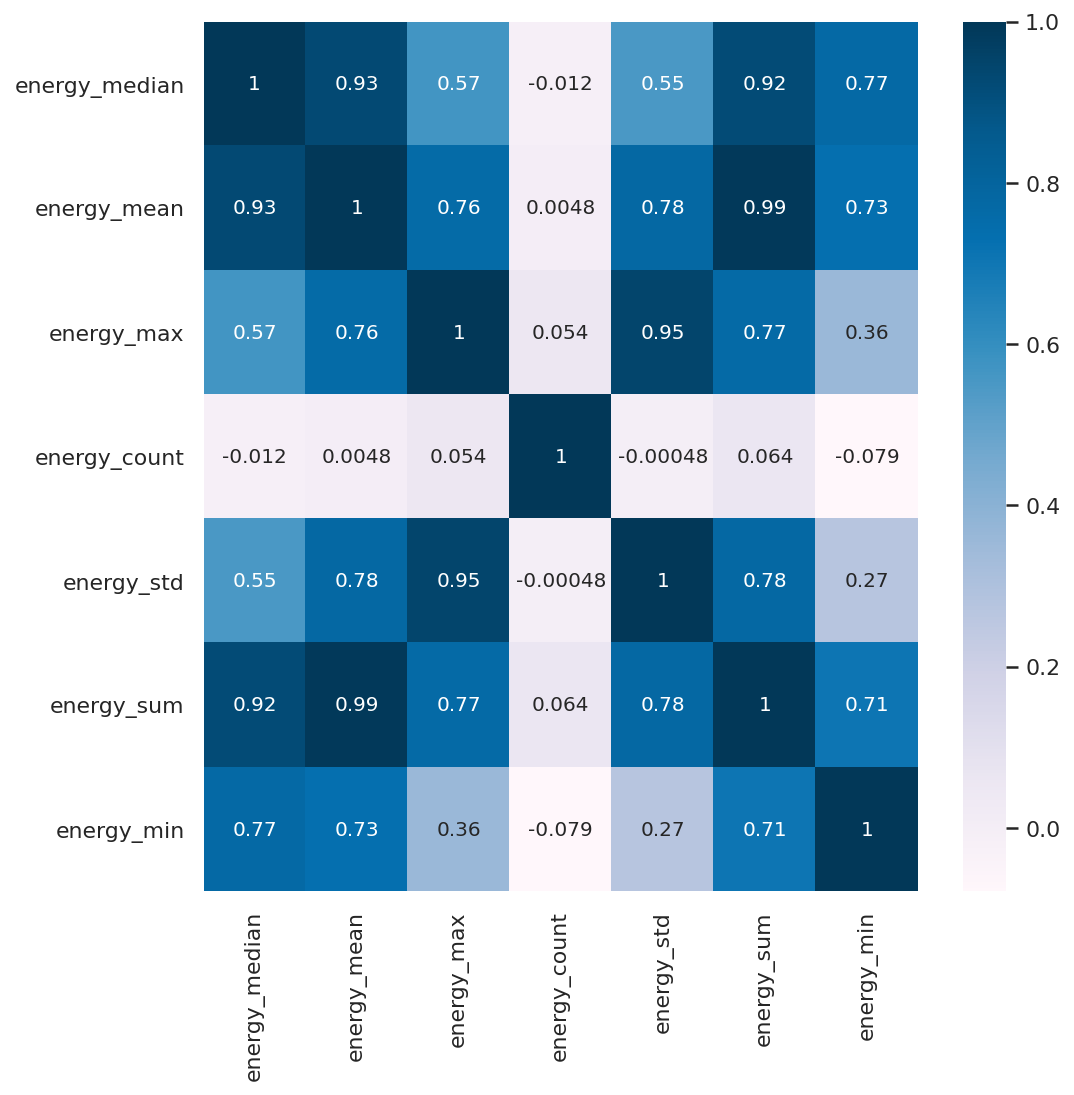

In [ ]:
# Plot numeric features correlation heat map 
def show_correlation_heatmap(dataframe):
    plt.figure(figsize=(8,8))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
    plt.show()
show_correlation_heatmap(df_daily)

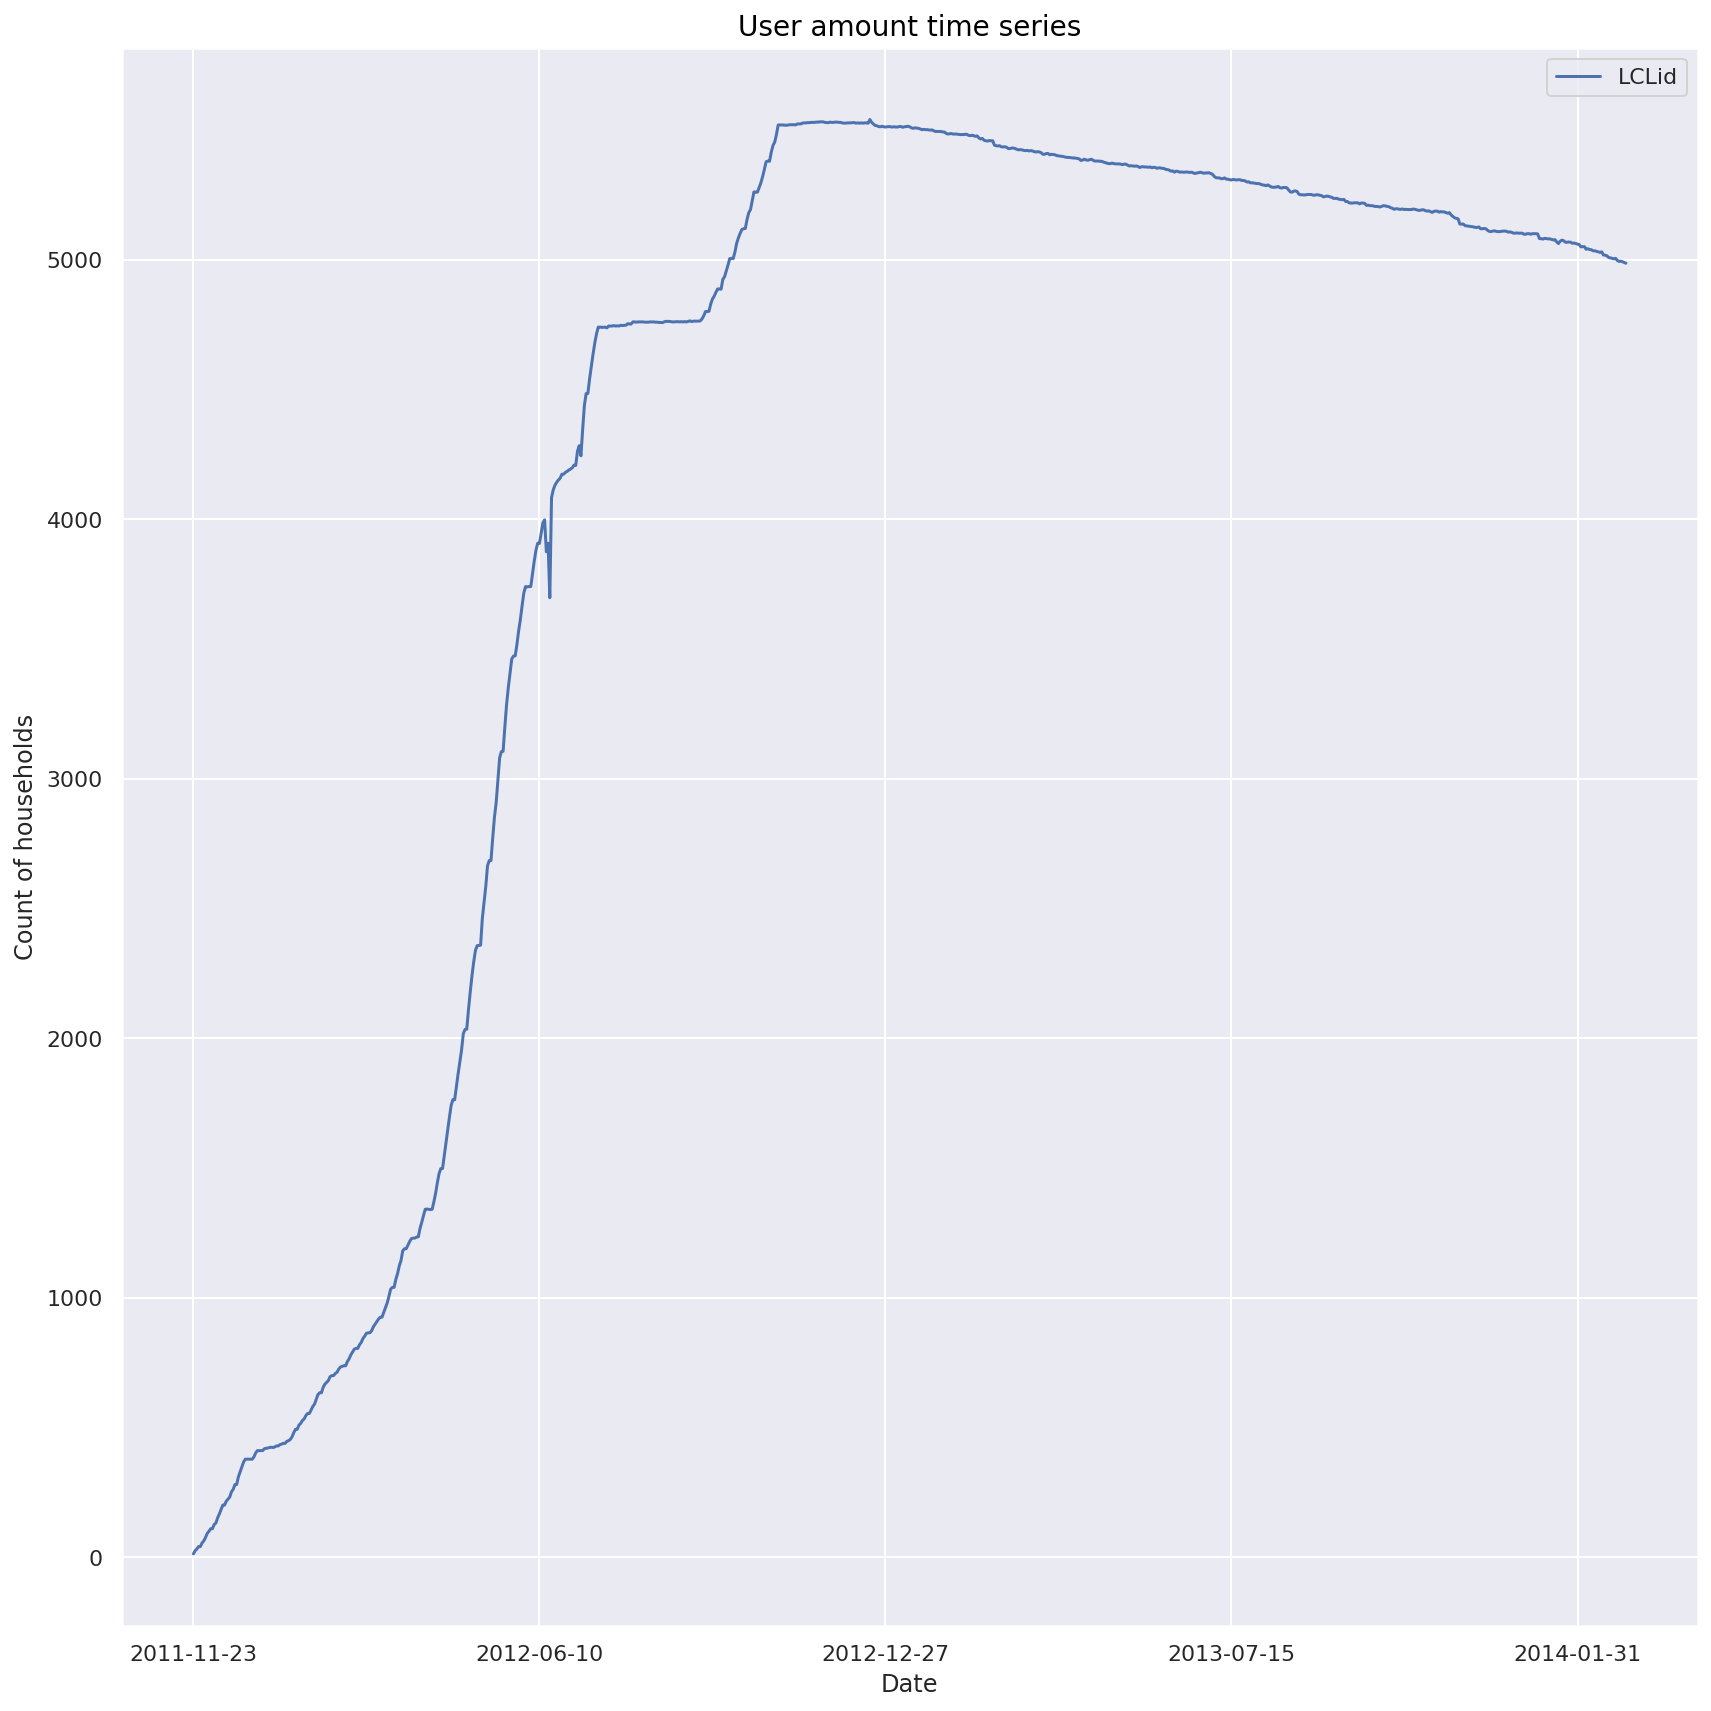

In [ ]:
# Plot energy user amount time series
df_count=df_daily[['LCLid', 'day']].groupby(["day"]).count()
fig,ax=plt.subplots(figsize=(12,12))
df_count.plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("Count of households")
plt.title("User amount time series",fontsize=14, color='black')
fig.tight_layout()
plt.show()

In [ ]:
# Prepare plotting dataset
df_consump = df_daily[['day', 'energy_min', 'energy_max']].groupby(['day'], as_index=False).mean()

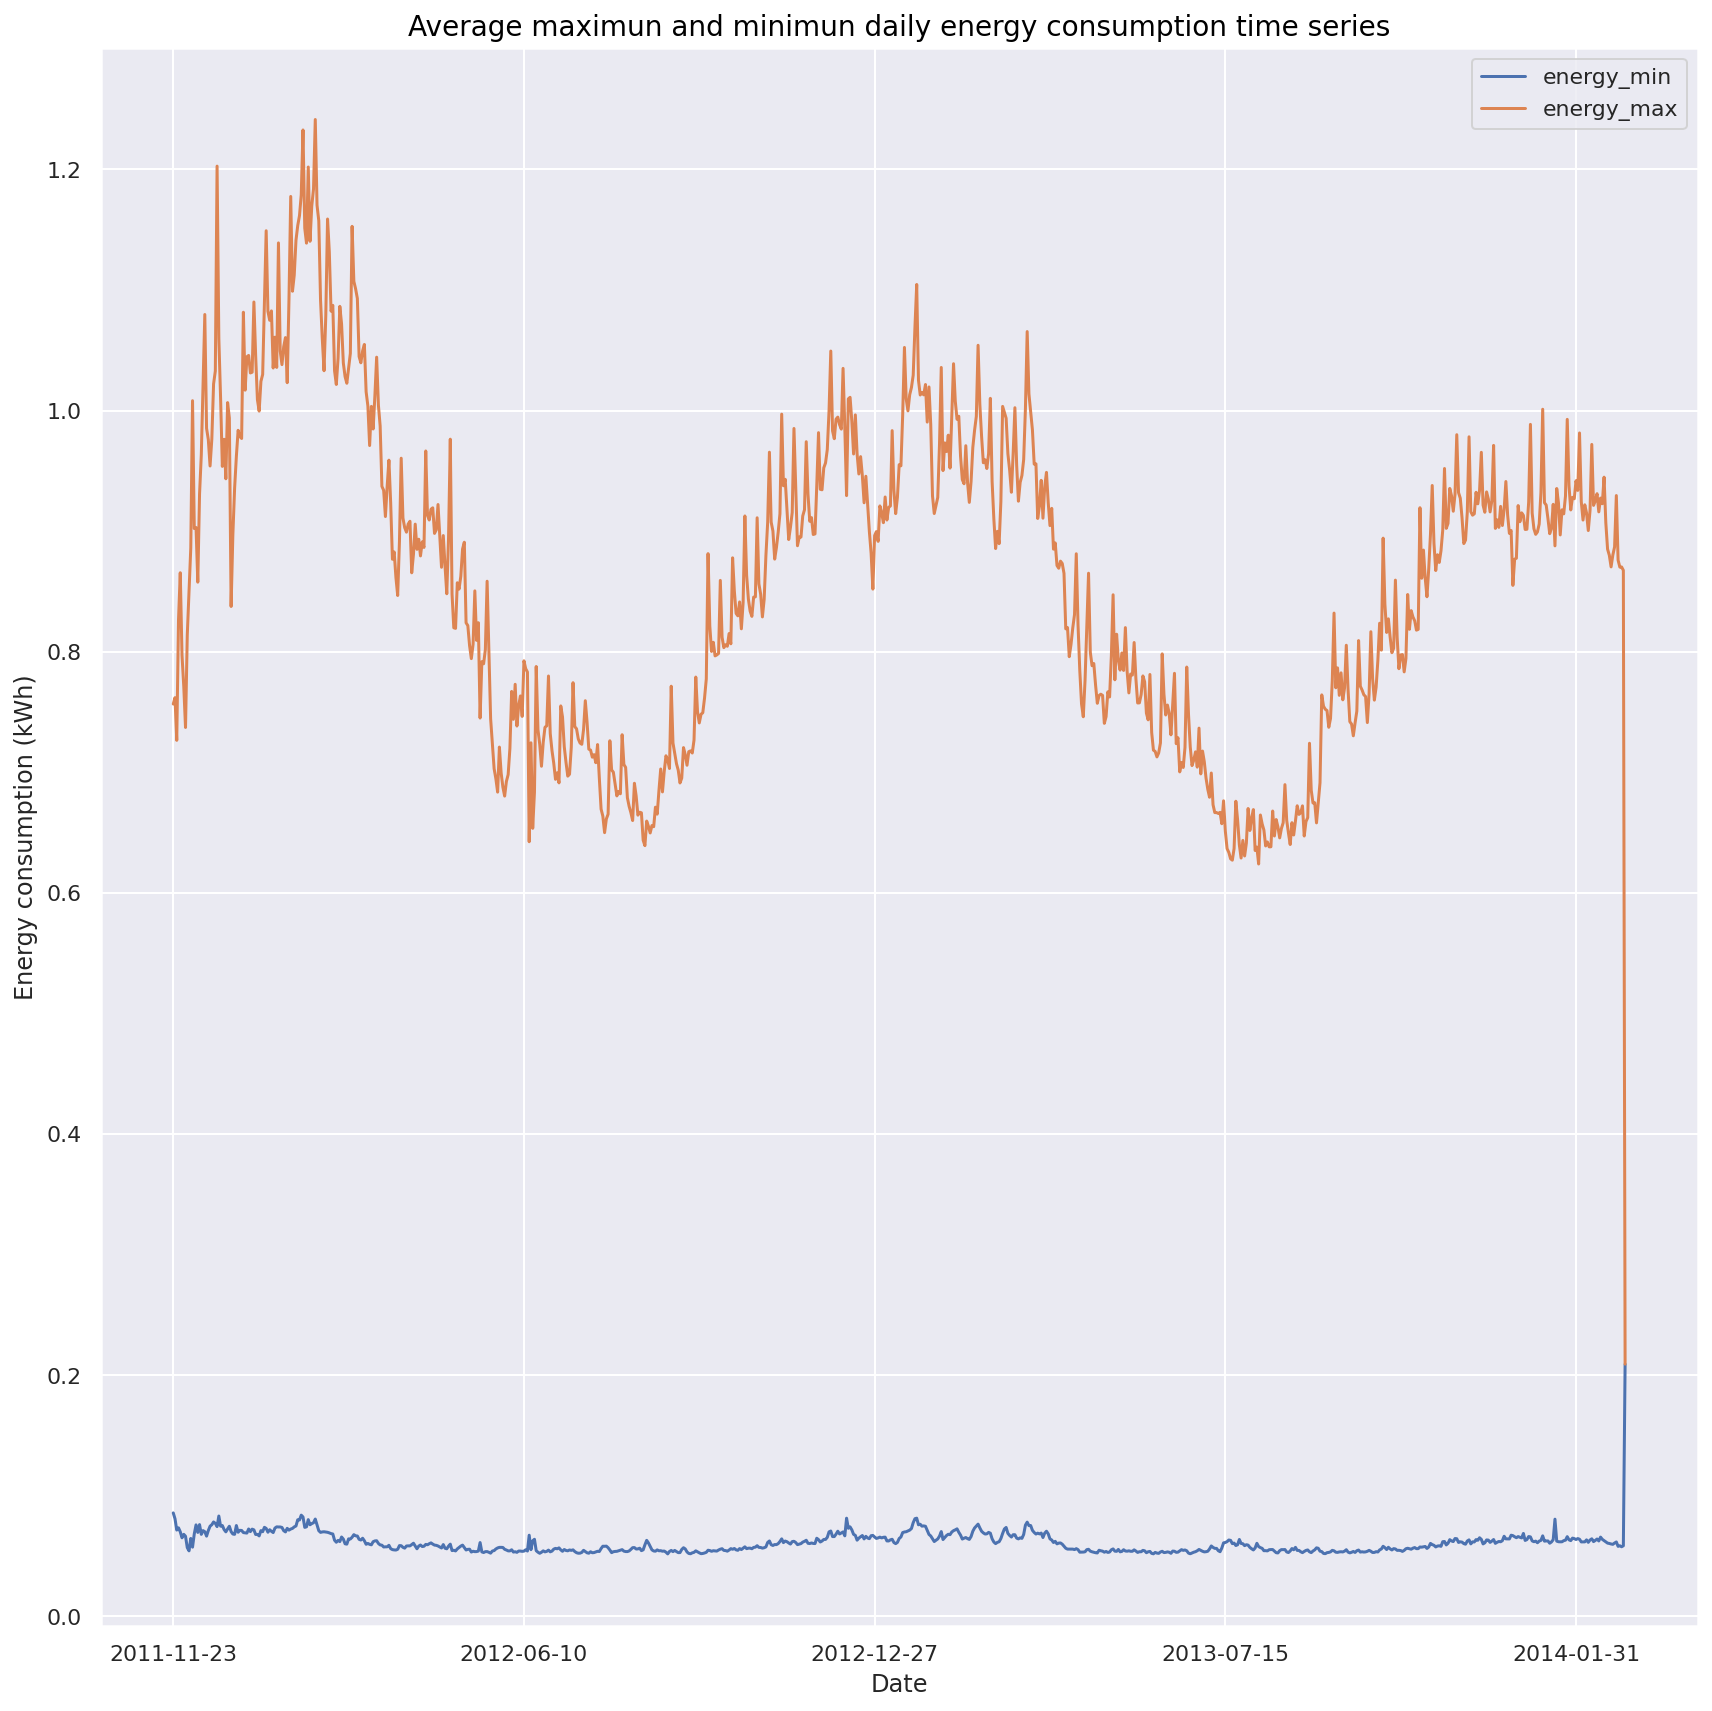

In [ ]:
# Plot average daily max and min enery consumption
fig,ax=plt.subplots(figsize=(12,12))
df_consump.plot(x='day',ax=ax)
plt.xlabel("Date")
plt.ylabel("Energy consumption (kWh)")
plt.title("Average maximun and minimun daily energy consumption time series",fontsize=14, color='black')
fig.tight_layout()
plt.show()

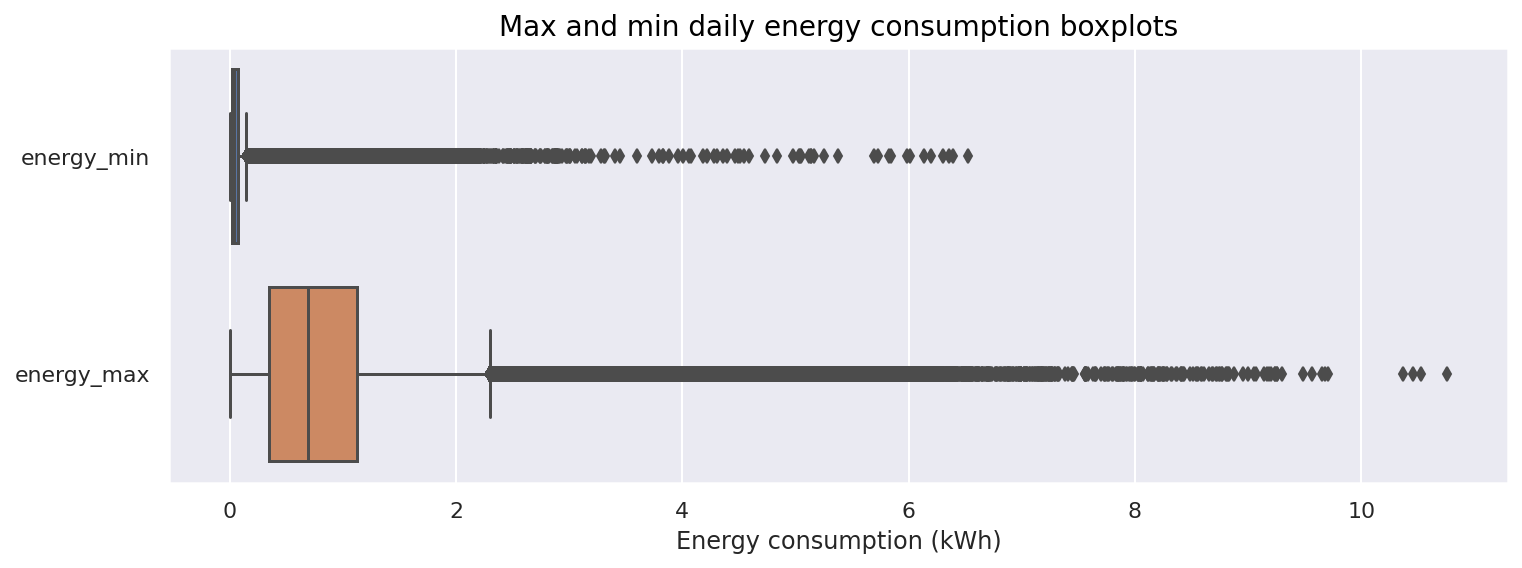

In [ ]:
# energy_max and energy_min boxplot
df_daily_box = df_daily[['energy_min', 'energy_max']]
fig,ax=plt.subplots(figsize=(12,4))
ax = sns.boxplot(data=df_daily_box, orient="h")
plt.title("Max and min daily energy consumption boxplots",fontsize=14, color='black')
plt.xlabel("Energy consumption (kWh)")
plt.show()

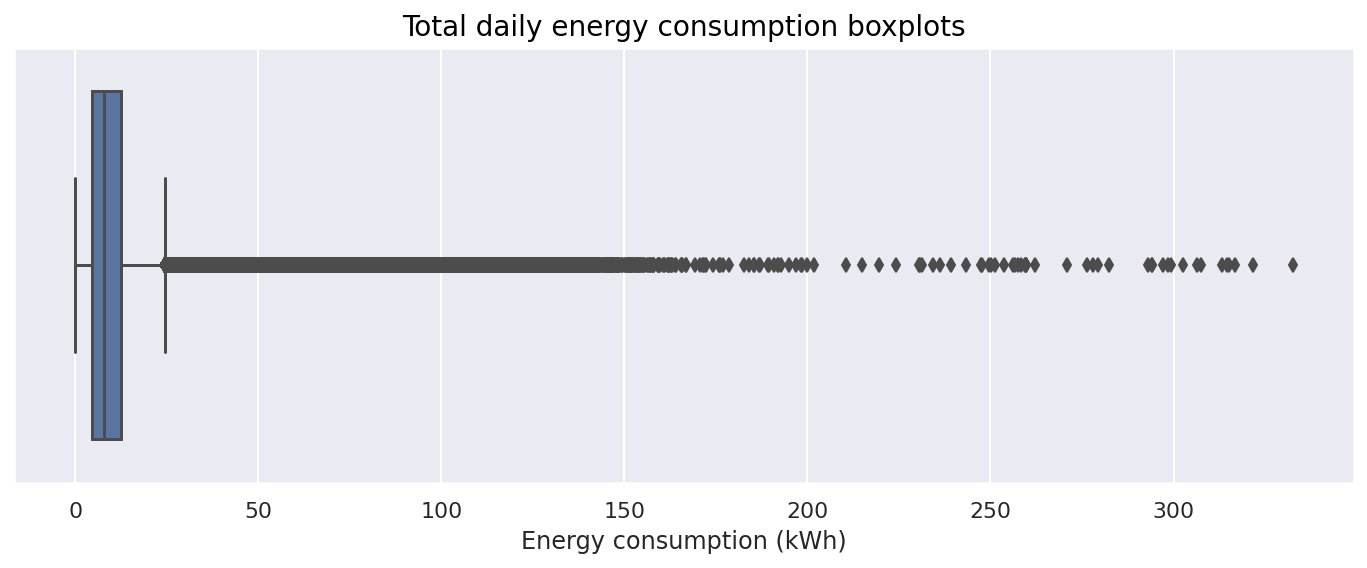

In [ ]:
# energy_sum boxplot
fig,ax=plt.subplots(figsize=(12,4))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df_daily, x='energy_sum', orient="h")
plt.title("Total daily energy consumption boxplots",fontsize=14, color='black')
plt.xlabel("Energy consumption (kWh)")
plt.show()

In [ ]:
# Read daily weather data
df_weather = pd.read_csv(os.path.join(base_dir, "weather.csv"))

In [ ]:
# Correct weather date data type
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [ ]:
# Rename date column for daily consumption dataset get ready to join with weather datatset 
df_daily = df_daily.rename(columns={'day': 'date'})

In [ ]:
# Sum up daily total energy consumption by each day
df_daily_final = df_daily[['date', 'energy_sum']].groupby(['date'], as_index=False).sum()

In [ ]:
# Correct daily energy consumption date data type
df_daily_final['date'] = pd.to_datetime(df_daily_final['date'])

In [ ]:
# Join daily energy consumption dataset with daily weather dataset
df_daily_weather = df_daily_final.merge(df_weather, on='date', how='left')

In [ ]:
# Combine temperatureMax and temperatureMax features into one mean temp feature of the two
df_daily_weather['temp'] = (df_daily_weather['temperatureMax'] + df_daily_weather['temperatureMax']) / 2

In [ ]:
# Drop the temperatureMax and temperatureMax features after combining
df_daily_weather = df_daily_weather.drop(['temperatureMax', 'temperatureMin'], axis=1)

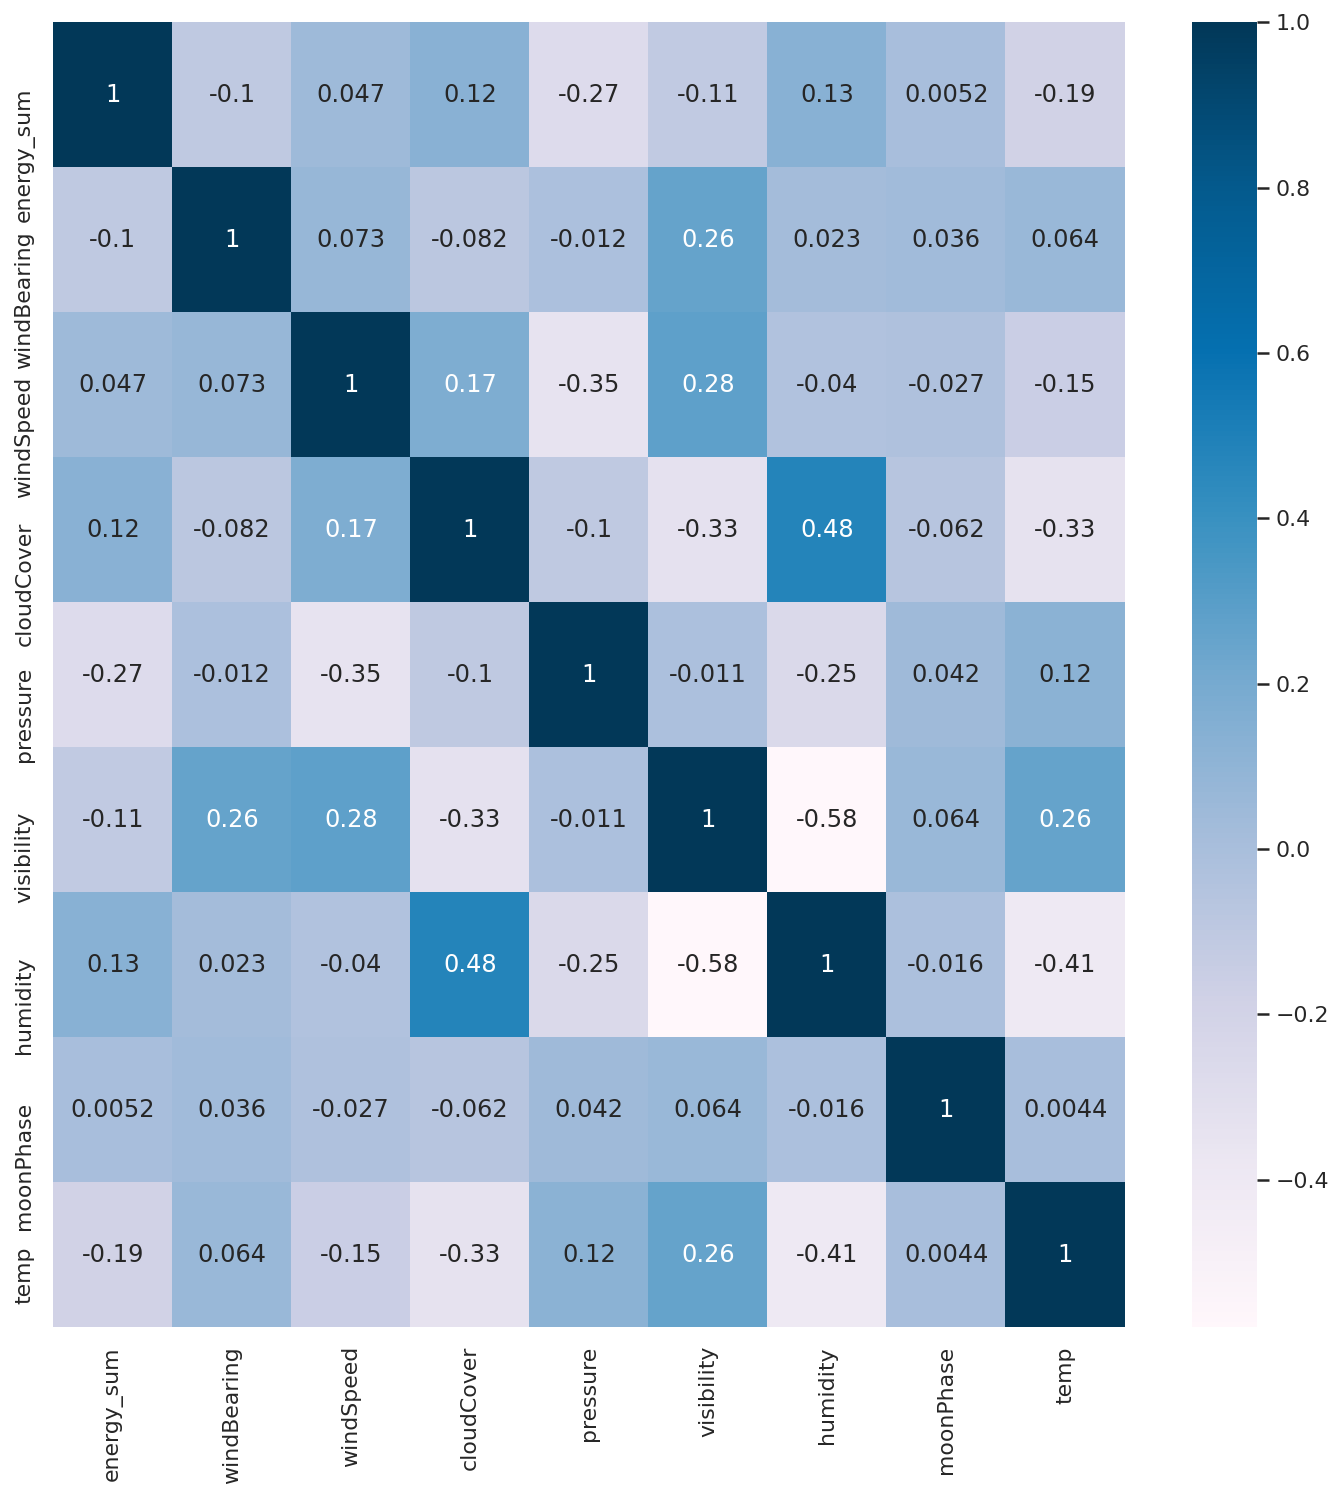

In [ ]:
# Plot numeric features heat map
def show_correlation_heatmap(dataframe):
    plt.figure(figsize=(12,12))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
    plt.show()
show_correlation_heatmap(df_daily_weather)

No handles with labels found to put in legend.


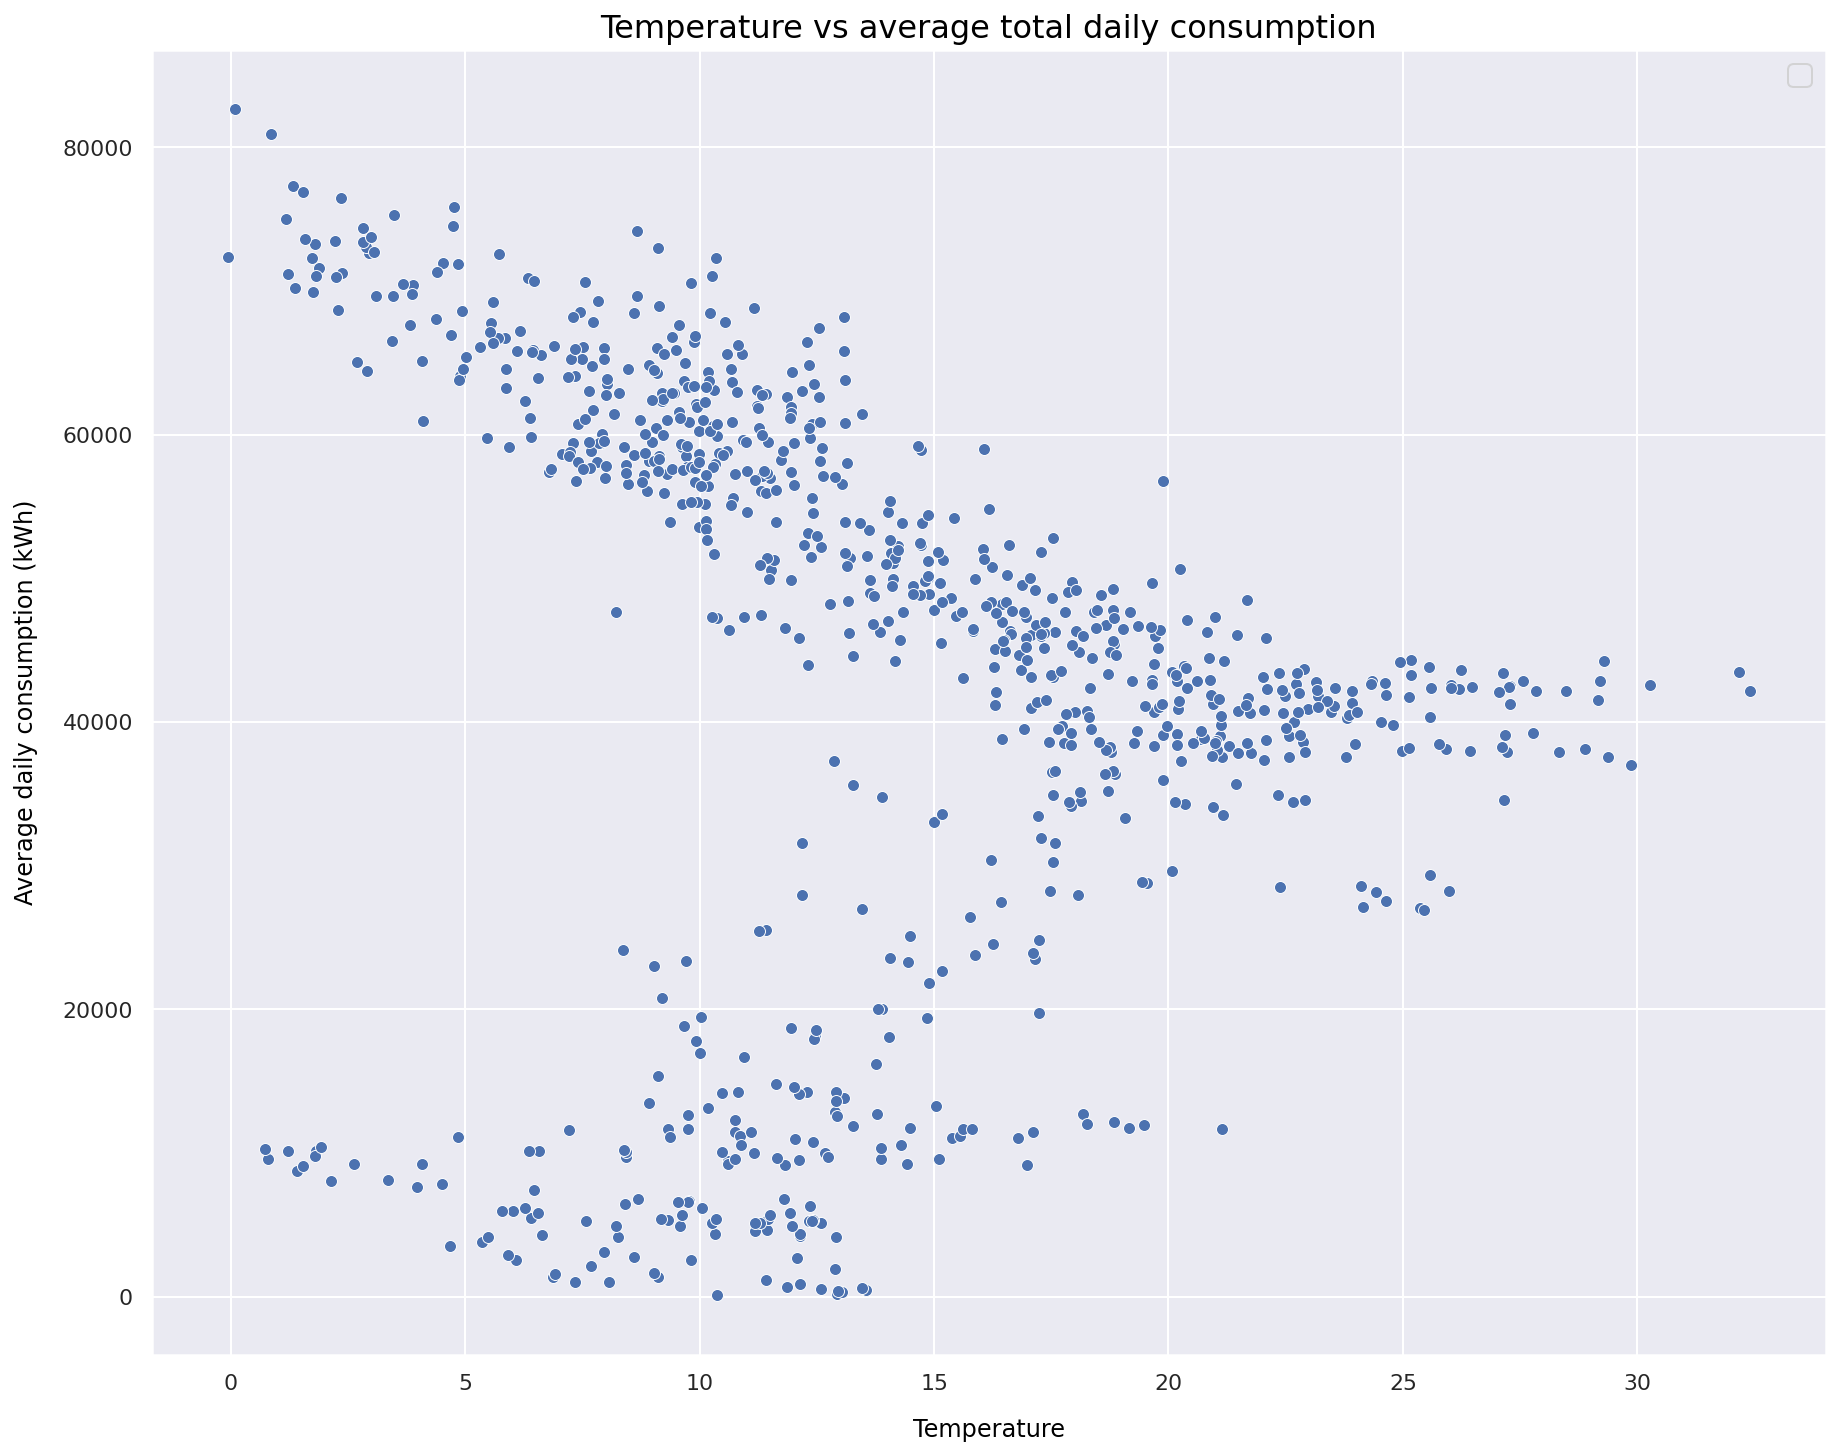

In [ ]:
# Plot daily temperature change vs average daily consumption change
plt.figure(figsize=(15,12))
sns.scatterplot(x='temp', y='energy_sum',data=df_daily_weather)
plt.xlabel("Temperature", fontsize=12,labelpad=12,color='black')
plt.ylabel("Average daily consumption (kWh)", fontsize=12,labelpad=12,color='black')
plt.title("Temperature vs average total daily consumption",fontsize=16, color='black')
plt.legend(loc='best', fontsize='large')
plt.show()

In [ ]:
# Save the joint dataset
df_daily_weather.to_csv(os.path.join(base_dir, "daily_weather.csv"), sep=',', index=False, encoding='utf-8')

In [ ]:
df_daily_weather.head()

,date,energy_sum,windBearing,windSpeed,cloudCover,pressure,visibility,humidity,icon,precipType,moonPhase,temp
0,2011-11-23,90.385000,229.0,2.04,0.36,1027.12,8.06,0.93,fog,rain,0.94,10.36
1,2011-11-24,213.412000,204.0,4.04,0.41,1027.22,10.64,0.89,partly-cloudy-night,rain,0.97,12.93
2,2011-11-25,303.993000,243.0,5.02,0.48,1024.47,12.38,0.79,partly-cloudy-day,rain,0.01,13.03
3,2011-11-26,420.976000,237.0,5.75,0.44,1025.80,13.07,0.81,wind,rain,0.05,12.96
4,2011-11-27,444.883001,256.0,5.48,0.42,1021.11,13.08,0.72,wind,rain,0.08,13.54
